In [1]:
import urllib.request
import pandas as pd
from os import getcwd, mkdir, listdir, chdir
import gzip
import pybedtools
from gprofiler import GProfiler
import numpy as np
import os, sys
import re
import glob
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
#Catalog structure

local_path = getcwd() 
mkdir(local_path + "/GO_enrichment/")
mkdir(local_path + "/Downloads/")
mkdir(local_path + "/Downloads/Uncompressed/")
mkdir(local_path + "/Downloads/Uncompressed/Pre-processing/")

In [3]:
# download

file = open("Transcription_factors.txt")
tf_id = []
download_links = []
with file as infile:
    for line in infile:
        tf_id.append(line.split()[1])
        download_links.append(line.split()[3])

download_links = download_links[1:]

for i in range(0, len(download_links)):
    urllib.request.urlretrieve(download_links[i], local_path + "/Downloads/" + tf_id[i+1] + ".gz")

In [4]:
#unziping transcription factors files

prefix = "TF0"
for i in range(21,41):
    name = str(prefix + str(i) + ".gz")
    with gzip.open(local_path + "/Downloads/" + name , "rb") as f:
        data = f.read()
        data = data.decode("utf-8")
        name = local_path + "/Downloads/Uncompressed/" + str(prefix + str(i) + ".bed")
    with open(name, "w") as file:
        file.write(data)
        
        
#Preprocessing
file = open(local_path + "/Transcription_factors.txt")
tf_id = []
tf_name = []
with file as infile:
    for line in infile:
        tf_name.append(line.split()[0])
        tf_id.append(line.split()[1])


refix = "TF0"
j = 1
for i in range(21,41):
    name = local_path + "/Downloads/Uncompressed/" + str(prefix + str(i) + ".bed")
    df = pd.read_csv(name, sep="\t")
    df[tf_id[j]] = tf_id[j]
    df[tf_name[j]] = tf_name[j]
    j += 1
    name = local_path + "/Downloads/Uncompressed/Pre-processing/" + str(prefix + str(i) + ".bed")
    df.to_csv(name, sep = "\t", index = False)

In [5]:
extract_path = local_path + "/Downloads/Uncompressed/Pre-processing/"
file_names = listdir(extract_path)
save_path = getcwd() + "/intersection.bed"


merged = ""
for file in file_names:
    file_path = extract_path + "/" + file
    with open(file_path, "r") as f:
        content = f.read()
        merged += content

path_merged = local_path + "/merged.bed"
with open(path_merged, "w") as f:
    f.write(merged)

a = pybedtools.BedTool(local_path + "/REMAnnotation.bed")
b = path_merged
a.intersect(b, f = 0.5,  filenames = True, sortout = True, header = True, wo = True).saveas(save_path)
    

final_save = local_path + "/cut_intersection.bed"
df = pd.read_csv(save_path, sep = "\t", skiprows = 1)
df_2 = pd.DataFrame()
#print(df.head(50))
df_2["REMID"] = df.iloc[:,4]
#print(df_2)
df_2["TF_ID"] = df.iloc[:,-3]
df_2["TF_NAME"] = df.iloc[:,-2]

df_2.to_csv(final_save, sep = "\t")

/home/nellman/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (13) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [6]:
intersection = pd.read_csv(local_path + "/intersection.bed", sep='\t', engine='python')
cut_intersection = pd.read_csv(local_path + "/cut_intersection.bed", sep='\t', engine='python')
intersection_full = pd.read_csv(local_path + "/intersection.bed", sep='\t', skiprows =1)

In [7]:
#How many times does a specific REMID occur
y = cut_intersection['REMID'].value_counts()
print("How many times does a specific REMID occur? \n", y)

#How many peaks per TFs overlap with a REM?
x = cut_intersection['TF_NAME'].value_counts()
print("\n")
print("How many peaks per TFs overlap with a REM? \n", x)

# What’s the average overall TFs you analysed?
df = pd.DataFrame(x)
tf_sum = df["TF_NAME"].sum()
tf_number = len(cut_intersection['TF_NAME'].unique())
mean = tf_sum/tf_number
print("What’s the average overall TFs you analysed? \n", mean)

How many times does a specific REMID occur? 
 REM1112246    16
REM1716342    16
REM1912108    16
REM1914916    16
REM1912109    16
              ..
REM0357017     1
REM1114492     1
REM2335786     1
REM0969176     1
REM2088161     1
Name: REMID, Length: 807069, dtype: int64


How many peaks per TFs overlap with a REM? 
 SOX6      267145
TCF12     151599
REST      136828
IRF9      134472
ZHX1      122235
E2F7      117692
ATF2      116030
MEIS2     113681
UBTF       37080
MAFK       30437
CUX1       22481
CTCF       17187
TEAD4      13549
DACH1       9513
NFYA        6049
USF1        5991
NRF1        4099
GATA2       4029
ZBTB33      1323
SFPQ         151
Name: TF_NAME, dtype: int64
What’s the average overall TFs you analysed? 
 65578.55


In [8]:
#What is th eaverage overlap between TF-Chip-seq peak and REM per TF experiment?
tf_ids = list(set(intersection.iloc[:,-3]))
my_list = []
for tf_id in tf_ids:
# get only the rows for a specific transcription factor
    is_tf = intersection.iloc[:,-3] == tf_id
    df = intersection[is_tf]
    overlap = df.iloc[:,-1].sum()
    count = df.iloc[:,-1].count()
    average = overlap/count
    my_list.append(average)
my_dict = dict(zip(tf_ids, my_list))
print(my_dict)

{'TF027': 132.73558554343148, 'TF023': 145.99988564491866, 'TF032': 131.42980694865847, 'TF028': 153.48349048855013, 'TF039': 170.8323624595469, 'TF040': 146.51413854725112, 'TF022': 123.32231680854615, 'TF026': 158.71780614741337, 'TF031': 159.55430649694165, 'TF037': 155.53642384105962, 'TF034': 140.6678210278432, 'TF030': 167.1752295855051, 'TF025': 117.2625240006982, 'TF029': 155.16391309219088, 'TF021': 133.10518132073548, 'TF038': 144.24566967553062, 'TF024': 121.59939531368103, 'TF033': 147.52889925144189, 'TF036': 142.4895564248284, 'TF035': 154.00344227789634}


In [9]:
#How many REMs overlap with more than one TF’s binding sites?
df2 = cut_intersection.groupby('REMID')['TF_NAME'].unique()


This many REMs overlapp with the specified number of TFs:  82


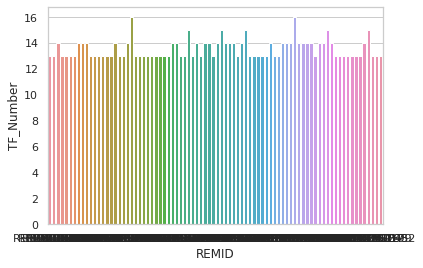

In [10]:
#Run this cell only if you have the computational power requiered to generate the plot!

df3 = pd.DataFrame(df2)
df3["TF_Number"] = df3["TF_NAME"].str.len()
df3["REMID"] = df3.index

#filter REMID that overlapp more than 12 TFs (Default value). Please Select the Number to filter.
is1 = df3["TF_Number"] > 12
df = df3[is1]

print("This many REMs overlapp with the specified number of TFs: ", len(df))
#generate a barplot - this is a time killer - not optimized

sns.set(style="whitegrid")
rem_plot = sns.barplot(y="TF_Number", x="REMID", data=df)


In [11]:
#initalise file path
path = local_path + "/intersection.bed"
intersection = None

# get the wanted coulumns
intersection = pd.DataFrame()
intersection["geneID"] = intersection_full.iloc[:,3]
intersection["TF_NAME"] = intersection_full.iloc[:,-3]
intersection["TF_ID"] = intersection_full.iloc[:,-3]

In [12]:
#GO enrichtment analysis

tf_ids = list(set(intersection["TF_ID"]))

# loop through every transcription factor for go:enrichment
for tf_id in tf_ids:
    # get only the rows for a specific transcription factor
    is_tf = intersection["TF_ID"] == tf_id
    df = intersection[is_tf]
    
    # extract unique gene IDs
    gene_ids = list(set(df["geneID"]))
    
    # use go:enrichment for the se genes
    gp = GProfiler(return_dataframe=True)
    go_enrichment = gp.profile(organism='hsapiens', query= gene_ids)
    go_enrichment["TF_ID"] = tf_id
    
    # get only GO:CC data and keep only the first 10 rows
    is_go = go_enrichment["source"] == "GO:CC"
    go_enrichment = go_enrichment[is_go]
    go_enrichment = go_enrichment.iloc[:10]
    enriched = pd.DataFrame()
    enriched["TF_ID"] = go_enrichment["TF_ID"]
    enriched["ExternalID"] = go_enrichment["native"]
    enriched["Function"] = go_enrichment["name"]
    

    # save as .csv
    path = local_path + "/GO_enrichment/" + tf_id + ".csv"
    enriched.to_csv(path, index = False)

In [13]:
#merge output GO to one file 
chdir(local_path + "/GO_enrichment/")
extension = 'csv'
all_filenames = [i for i in glob.glob('*.{}'.format(extension))]
#combine all files in the list
combined_csv = pd.concat([pd.read_csv(f) for f in all_filenames ])
#export to csv
combined_csv.to_csv("combined_csv.csv", index=False, encoding='utf-8-sig')

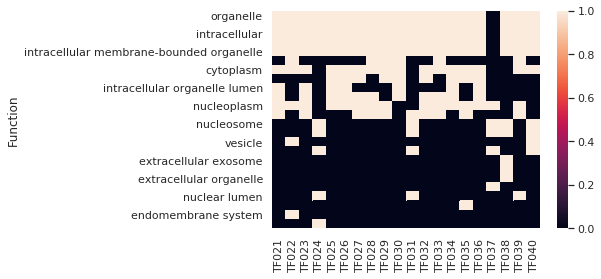

In [14]:
#generate a heatmap for Gene ontology and our transcription factors

file = pd.read_csv(local_path + "/GO_enrichment/combined_csv.csv")
file = file[~file.reset_index().duplicated().values]
file = file[['TF_ID','Function']]
df1 = pd.get_dummies(file.set_index("Function")["TF_ID"]).max(level=0).reset_index()
sns.set()
df2 = df1.set_index('Function')
sns.heatmap(df2)
plt.show()